In [1]:
# !pip install --user matplotlib seaborn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [4]:
from tensorflow.keras.models import load_model

In [5]:
from bert.layers import Attention, Transformer, DenseNoMask, PositionEmbedding
from bert.optimizers import ECE, masked_sparse_categorical_crossentropy

In [6]:
# log = pd.read_csv('/scratch/pstjohn/transformer_base_512_checkpoints/log.csv')

In [81]:
from bert.model import create_albert_model
model = create_albert_model(model_dimension=512,
                            transformer_dimension=512 * 4,
                            num_attention_heads=512 // 64,
                            num_transformer_layers=6,
                            vocab_size=22,
                            dropout_rate=0.)

In [7]:
# model = load_model('../uniparc_checkpoints/test.h5', 
#                    custom_objects={
#                        'Transformer': Transformer,
#                        'Attention': Attention,
#                        'DenseNoMask': DenseNoMask,
#                        'PositionEmbedding': PositionEmbedding,
#                        'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
#                        'ECE': ECE})

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [96]:
from bert.dataset import create_masked_input_dataset

valid_data = create_masked_input_dataset(
    sequence_path='../uniparc_data/sequences_valid.txt',
    max_sequence_length=1024,
    batch_size=12)

In [97]:
masked_seq, true_values = next(iter(valid_data))
ECE(true_values, model.predict(masked_seq))

<tf.Tensor: id=22845, shape=(), dtype=float32, numpy=22.978378>

In [98]:
predictions = tf.nn.softmax(model.predict(masked_seq))

In [99]:
masked_entries = tf.not_equal(true_values, 0)
y_true_mask = tf.boolean_mask(true_values, masked_entries)
y_pred_mask = tf.boolean_mask(predictions, masked_entries)

In [100]:
import pandas as pd

In [101]:
aas = ['0', 'MASK', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
confusion_mat = pd.DataFrame(y_pred_mask.numpy()).groupby(y_true_mask.numpy()).sum()
confusion_mat.columns = aas
confusion_mat.index = aas[2:]

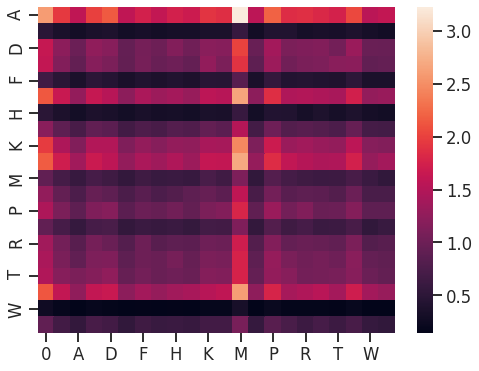

In [102]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat)

In [103]:
model.layers

In [104]:
inputs = tf.keras.Model(model.layers[1].input, model.layers[1].output)(masked_seq)

In [106]:
transformer = model.layers[-2]

In [107]:
self = transformer.attention_layer
mask = inputs._keras_mask
training=True

from bert.attention_utils import create_attention_mask, relative_attention_inner, initializer

In [124]:
input_shape = tf.shape(inputs) # [B, S, N*H]

# query and key can be the same vector
qk = self.transpose_scores(self.qk_layer(inputs))  # [B,N,S,H]
value = self.transpose_scores(self.value_layer(inputs))  # [B,N,S,H]

# Equation 1 of "Attention is all you need"
attention_scores = self.calculate_attention(qk, input_shape)  # [B,N,S,S]

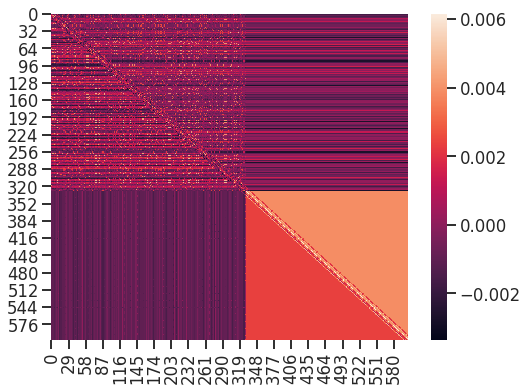

In [125]:
plt.figure(figsize=(8,6))
sns.heatmap((attention_scores[0, 0]).numpy())

In [126]:
# zero out masked values
attention_mask = self.create_attention_mask(input_shape, mask)
attention_scores = attention_scores * 1000 + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores)  # [B,N,S,S]

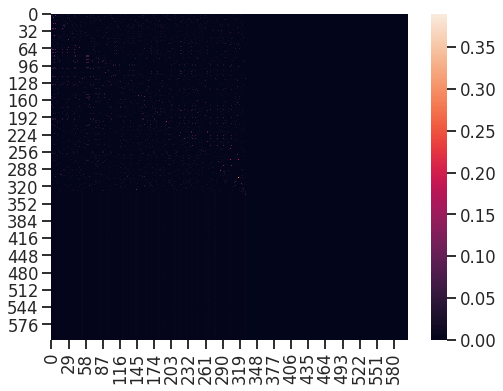

In [135]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[0, 0].numpy())

In [136]:
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

In [137]:
context_layer.shape

TensorShape([12, 8, 605, 64])

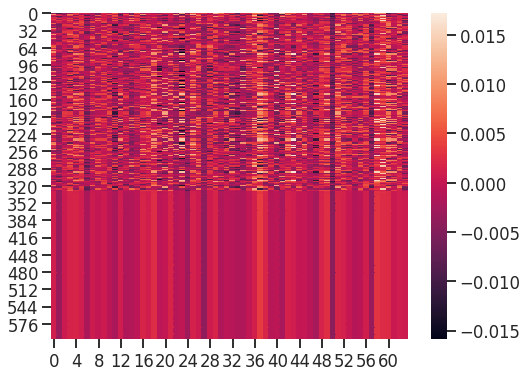

In [138]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[0, 0].numpy())

In [139]:
context_layer = tf.transpose(a=context_layer, perm=[0, 2, 1, 3])            

In [140]:
context_layer.shape

TensorShape([12, 605, 8, 64])

In [141]:
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
context_layer = tf.reshape(context_layer, output_shape)

In [142]:
context_layer.shape

TensorShape([12, 605, 512])

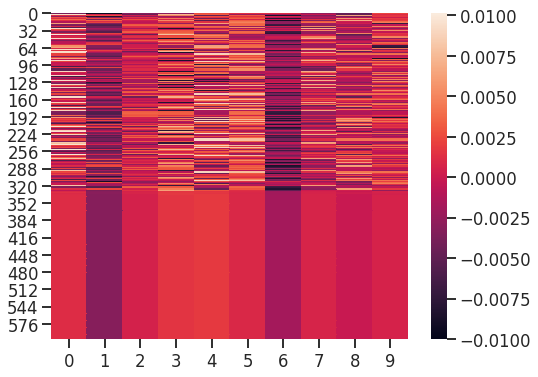

In [145]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[0, :, :10].numpy())

In [ ]:
mask = inputs._keras_mask
attention_mask = self.create_attention_mask(mask)
attention_scores_mask = attention_scores + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores_mask)  # [B,N,S,S]
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

input_shape  = tf.shape(inputs)
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
# context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[3, 0].numpy())

In [ ]:
context_layer.shape

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(tf.reshape(tf.transpose(a=context_layer, perm=[0, 2, 1, 3]), input_shape)[3].numpy())